In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
# For GPU usage
!nvidia-smi

Tue Feb 25 15:32:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data Collection

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 98% 721M/736M [00:08<00:00, 122MB/s]
100% 736M/736M [00:08<00:00, 92.7MB/s]


In [ ]:
!ls /content

eye-diseases-classification.zip  sample_data


In [ ]:
!rm -rf /content/dataset

In [ ]:
!unzip /content/eye-diseases-classification.zip -d /content/dataset/

Archive:  /content/eye-diseases-classification.zip
  inflating: /content/dataset/dataset/cataract/0_left.jpg  
  inflating: /content/dataset/dataset/cataract/103_left.jpg  
  inflating: /content/dataset/dataset/cataract/1062_right.jpg  
  inflating: /content/dataset/dataset/cataract/1083_left.jpg  
  inflating: /content/dataset/dataset/cataract/1084_right.jpg  
  inflating: /content/dataset/dataset/cataract/1102_left.jpg  
  inflating: /content/dataset/dataset/cataract/1102_right.jpg  
  inflating: /content/dataset/dataset/cataract/1115_left.jpg  
  inflating: /content/dataset/dataset/cataract/1126_right.jpg  
  inflating: /content/dataset/dataset/cataract/112_right.jpg  
  inflating: /content/dataset/dataset/cataract/1144_left.jpg  
  inflating: /content/dataset/dataset/cataract/1144_right.jpg  
  inflating: /content/dataset/dataset/cataract/1164_left.jpg  
  inflating: /content/dataset/dataset/cataract/1167_right.jpg  
  inflating: /content/dataset/dataset/cataract/119_left.jpg  
  i

# Data Preprocessing

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

import keras_tuner as kt

from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, SimpleRNN, Reshape, Average, GlobalAveragePooling2D, Dropout

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define custom F1-Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update precision and recall
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Calculate F1 score using precision and recall
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [ ]:
# Path to the dataset
dataset_dir = '/content/dataset/dataset'

In [ ]:
# List the classes (directories in dataset)
class_names = os.listdir(dataset_dir)
print("Class Names:", class_names)

Class Names: ['glaucoma', 'diabetic_retinopathy', 'normal', 'cataract']


In [ ]:
# Function to check if a file is an image based on extension
def is_image(file_name):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']
    return any(file_name.lower().endswith(ext) for ext in valid_extensions)

## Removing Duplicated Images

In [ ]:
class_image_files = defaultdict(set)  # To store filenames of images per class
duplicates_found = False  # Flag to track if duplicates are found

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Check if the file is already listed under this class
                if file_name in class_image_files[class_name]:
                    print(f"Duplicate found in class '{class_name}': {file_name}")
                    duplicates_found = True
                else:
                    class_image_files[class_name].add(file_name)

if not duplicates_found:
    print("No duplicate images found in any class.")

No duplicate images found in any class.


In [ ]:
all_image_files = defaultdict(set)  # To store filenames across all classes
duplicates_found_across_classes = False  # Flag to track if duplicates are found across classes

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Check for duplicates across different classes
                if file_name in all_image_files:
                    print(f"Duplicate found across classes: '{file_name}' in classes '{all_image_files[file_name]}' and '{class_name}'")
                    duplicates_found_across_classes = True
                else:
                    all_image_files[file_name].add(class_name)

if not duplicates_found_across_classes:
    print("No duplicate images found across classes.")

Duplicate found across classes: '1415_right.jpg' in classes '{'glaucoma'}' and 'cataract'
Duplicate found across classes: '625_left.jpg' in classes '{'glaucoma'}' and 'cataract'


In [ ]:
# List of files to delete
file_paths = [
    '/content/dataset/dataset/cataract/625_left.jpg',
    '/content/dataset/dataset/glaucoma/625_left.jpg',
    '/content/dataset/dataset/cataract/1415_right.jpg',
    '/content/dataset/dataset/glaucoma/1415_right.jpg'
]

# Loop through the file paths and delete each one
for file_path in file_paths:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted {file_path}")
    else:
        print(f"The file {file_path} does not exist.")

Deleted /content/dataset/dataset/cataract/625_left.jpg
Deleted /content/dataset/dataset/glaucoma/625_left.jpg
Deleted /content/dataset/dataset/cataract/1415_right.jpg
Deleted /content/dataset/dataset/glaucoma/1415_right.jpg


Let's check the data distribution again.

In [ ]:
# Initialize dictionaries to store image format counts and class distribution
image_format_counts = defaultdict(int)
class_image_counts = defaultdict(int)  # To count images per class
total_images = 0  # Total count of images

In [ ]:
# Initialize a list to store image sizes
image_sizes = []

In [ ]:
# Loop through the dataset and count image formats, class distributions, and sizes
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)

    # Check if it's a directory (class folder)
    if os.path.isdir(class_path):
        # Initialize class image counter
        class_count = 0
        # Loop through each file in the class directory
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Count the image format (extension)
                file_extension = os.path.splitext(file_name)[-1].lower()
                image_format_counts[file_extension] += 1
                # Increment the class image count
                class_count += 1
                total_images += 1

                # Load the image to get its size
                img = Image.open(os.path.join(class_path, file_name))
                image_sizes.append((class_name, img.size))  # Store (class_name, (width, height))

        # Update class distribution
        class_image_counts[class_name] = class_count

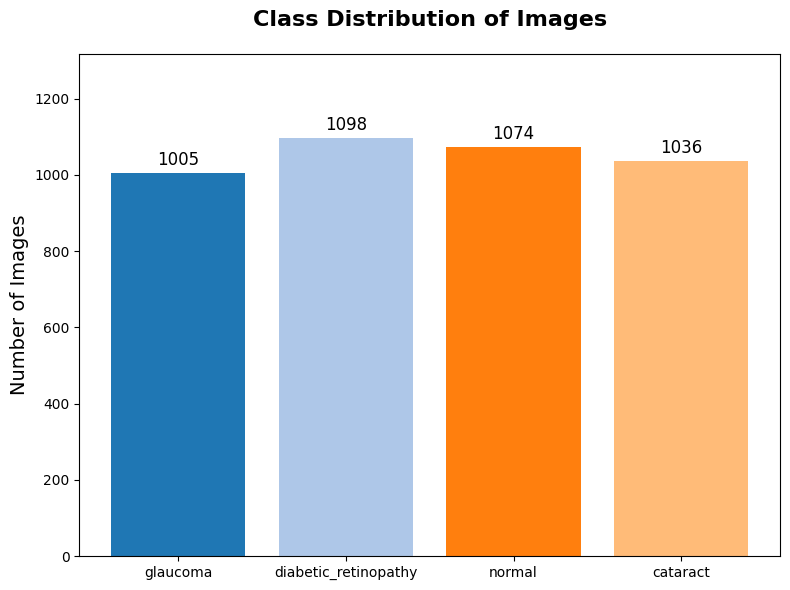

In [ ]:
# Generate a list of colors for each bar (one color per class)
colors = plt.colormaps['tab20'].colors  # Access the 'tab20' colormap
colors = (colors * ((len(class_image_counts) // len(colors)) + 1))[:len(class_image_counts)]

# Create a bar plot for class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(class_image_counts.keys(), class_image_counts.values(), color=colors)

# Add counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height), ha='center', va='bottom', fontsize=12)

plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution of Images', fontsize=16, fontweight='bold', pad = 20)

# Adjust y-axis limit to be 12% more than the maximum value
y_max = max(class_image_counts.values())
plt.ylim(0, y_max * 1.2)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

## Converting Image Format

In [ ]:
# Define input and output directories
dataset_dir = "/content/dataset/dataset"
output_dir = "/content/dataset/dataset_jpg"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Supported image formats (excluding .jpg since we don't need to convert it)
valid_extensions = ('.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

In [ ]:
%%time

# Loop through each subdirectory (category)
for subfolder in os.listdir(dataset_dir):
    subfolder_path = os.path.join(dataset_dir, subfolder)

    if os.path.isdir(subfolder_path):  # Ensure it's a folder
        output_subfolder = os.path.join(output_dir, subfolder)  # Maintain structure
        os.makedirs(output_subfolder, exist_ok=True)  # Create subfolder in output

        # Process images in the subfolder
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)

            if filename.lower().endswith(valid_extensions):  # Convert non-JPG images
                try:
                    img = Image.open(file_path).convert("RGB")
                    new_filename = os.path.splitext(filename)[0] + ".jpg"
                    img.save(os.path.join(output_subfolder, new_filename), "JPEG", quality=100)
                    # print(f"Converted: {subfolder}/{filename} → {new_filename}")
                except Exception as e:
                    print(f"Error processing {subfolder}/{filename}: {e}")  # Log errors
            elif filename.lower().endswith(".jpg"):  # Copy existing .jpg files
                src_path = os.path.join(subfolder_path, filename)
                dest_path = os.path.join(output_subfolder, filename)
                try:
                    if not os.path.exists(dest_path):  # Avoid redundant copies
                        with open(src_path, 'rb') as src_file, open(dest_path, 'wb') as dest_file:
                            dest_file.write(src_file.read())  # Perform a binary copy
                        # print(f"Copied: {subfolder}/{filename} (already .jpg)")
                except Exception as e:
                    print(f"Error copying {subfolder}/{filename}: {e}")

print("Conversion completed successfully.")

Conversion completed successfully.
CPU times: user 30.3 s, sys: 2.04 s, total: 32.4 s
Wall time: 32.6 s


## Resizing Image

**Resizing images to 224x224**

In [ ]:
# Define input and output directories
dataset_dir = "/content/dataset/dataset_jpg"
output_dir = "/content/dataset/dataset_jpg_resize_224"

# Target image size (change based on model)
target_size = (224, 224)  # Example: ResNet/MobileNet/Inception

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def resize_with_padding(img, target_size=(224, 224), padding_color=(0, 0, 0)):
    """
    Resizes an image while maintaining aspect ratio and adds padding if necessary.
    :param img: PIL Image object
    :param target_size: Tuple (width, height)
    :param padding_color: Background color for padding (default: black)
    :return: Resized and padded image
    """
    old_size = img.size  # (width, height)

    # Compute new size while maintaining aspect ratio
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))
    img = img.resize(new_size, Image.BILINEAR)

    # Create a new blank image and paste the resized image at the center
    new_img = Image.new("RGB", target_size, padding_color)
    paste_position = ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2)
    new_img.paste(img, paste_position)

    return new_img

In [ ]:
%%time

# Process each class folder inside the dataset
for class_folder in os.listdir(dataset_dir):
    class_folder_path = os.path.join(dataset_dir, class_folder)

    if os.path.isdir(class_folder_path):  # Ensure it's a folder
        output_class_folder = os.path.join(output_dir, class_folder)  # Maintain structure
        os.makedirs(output_class_folder, exist_ok=True)  # Create class subfolder in output

        # Process only .jpg images in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.lower().endswith(".jpg"):  # Process only .jpg images
                file_path = os.path.join(class_folder_path, filename)
                output_path = os.path.join(output_class_folder, filename)

                # Skip if the image already exists in the output folder
                if os.path.exists(output_path):
                    print(f"Skipping (already exists): {class_folder}/{filename}")
                    continue

                try:
                    img = Image.open(file_path).convert("RGB")  # Convert to RGB mode
                    img = resize_with_padding(img, target_size)  # Resize with aspect ratio maintained

                    # Save the resized image in the same format
                    img.save(output_path, "JPEG", quality=100)
                    # print(f"Resized: {class_folder}/{filename} to {target_size}")
                except Exception as e:
                    print(f"Error processing {class_folder}/{filename}: {e}")  # Log errors

print("Resizing completed successfully.")

Resizing completed successfully.
CPU times: user 31.8 s, sys: 4.18 s, total: 35.9 s
Wall time: 36.1 s


## Splitting The Dataset

In [ ]:
dataset_dir = '/content/dataset/dataset_jpg_resize_224'

In [ ]:
# Set image size and batch size
img_size = (224, 224)
batch_size = 32

# Define ImageDataGenerator with validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values to [0, 1]
    validation_split=0.2  # 80% for training, 20% for validation
)

# Load training data (80% of the dataset for training)
train_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data (20% of the dataset for validation)
val_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3372 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


# Model Building and Selection

## Baseline Model

In [ ]:
# Simple CNN model
model_cnn = Sequential([
    Input(shape=(224, 224, 3)),  # Input layer with shape (224, 224, 3) for RGB images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes for cataract, diabetic_retinopathy, glaucoma, normal
])

# Print model summary to check the layers
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      25,233,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,234,628 (96.26 MB)

 Trainable params: 25,234,628 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with F1-Score included in the metrics
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

In [ ]:
# Train the model
history_cnn = model_cnn.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.5529 - f1_score: 0.5081 - loss: 1.7949 - precision: 0.6065 - recall: 0.4381 - val_accuracy: 0.5589 - val_f1_score: 0.5611 - val_loss: 0.9023 - val_precision: 0.6039 - val_recall: 0.5240
Epoch 2/10
  1/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7500 - f1_score: 0.6885 - loss: 0.7198 - precision: 0.7241 - recall: 0.6562

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7500 - f1_score: 0.6885 - loss: 0.7198 - precision: 0.7241 - recall: 0.6562 - val_accuracy: 0.5733 - val_f1_score: 0.5742 - val_loss: 0.8797 - val_precision: 0.6198 - val_recall: 0.5349
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.7833 - f1_score: 0.7685 - loss: 0.5105 - precision: 0.8132 - recall: 0.7286 - val_accuracy: 0.5685 - val_f1_score: 0.5643 - val_loss: 1.1686 - val_precision: 0.5898 - val_recall: 0.5409
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8750 - f1_score: 0.8197 - loss: 0.4266 - precision: 0.8621 - recall: 0.7812 - val_accuracy: 0.5721 - val_f1_score: 0.5660 - val_loss: 1.0691 - val_precision: 0.5965 - val_recall: 0.5385
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.8006 - f1_score: 0.7940 - loss: 0.4570 - precision: 0.8170 - recall: 0.7722 - val_accuracy: 0.5625 - val_f1_score: 0.5649 - val_loss: 1.1195 - val_precision: 0.5788 - val_recall: 0.55

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy, train_precision, train_recall, train_f1_score = model_cnn.evaluate(
    train_data,
    steps=train_data.samples // train_data.batch_size
)

print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1-Score: {train_f1_score}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8871 - f1_score: 0.8853 - loss: 0.3080 - precision: 0.8943 - recall: 0.8765
Training Loss: 0.3088030219078064
Training Accuracy: 0.8812500238418579
Training Precision: 0.889091432094574
Training Recall: 0.8708333373069763
Training F1-Score: 0.8798676133155823


In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = model_cnn.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6327 - f1_score: 0.6228 - loss: 0.9203 - precision: 0.6458 - recall: 0.6013
Validation Loss: 0.8743487596511841
Validation Accuracy: 0.6394230723381042
Validation Precision: 0.6593830585479736
Validation Recall: 0.6165865659713745
Validation F1-Score: 0.6372670531272888


In [ ]:
print(history_cnn.history.keys())

dict_keys(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall'])


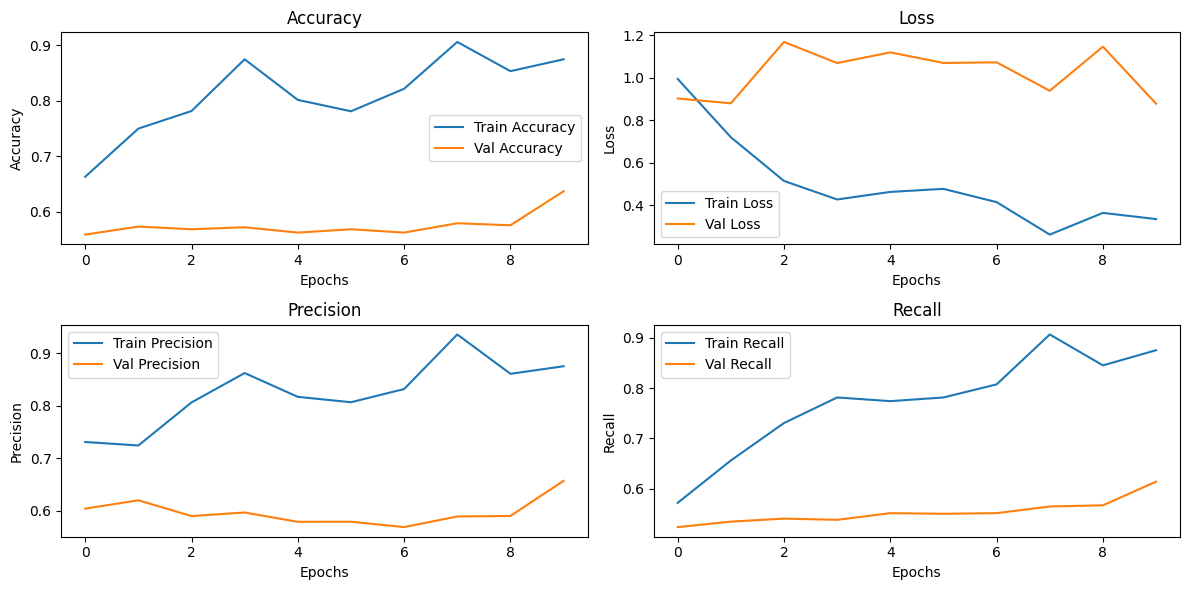

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history_cnn.history['precision'], label='Train Precision')
plt.plot(history_cnn.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history_cnn.history['recall'], label='Train Recall')
plt.plot(history_cnn.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## InceptionV3

In [ ]:
# InceptionV3 Model
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional: you can unfreeze some layers for fine-tuning)
inceptionv3_base.trainable = False

# Add custom classification head
x_inceptionv3 = inceptionv3_base.output
x_inceptionv3 = GlobalAveragePooling2D()(x_inceptionv3)  # Global Average Pooling
x_inceptionv3 = Dropout(0.2)(x_inceptionv3)  # Dropout for regularization
x_inceptionv3 = Dense(256, activation='relu')(x_inceptionv3)  # Fully connected layer
inceptionv3_predictions = Dense(4, activation='softmax')(x_inceptionv3)  # 4 classes

# Final InceptionV3 model
inceptionv3_model = Model(inputs=inceptionv3_base.input, outputs=inceptionv3_predictions)

# Compile the model
inceptionv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

# Train the model
history_inceptionv3 = inceptionv3_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.6211 - f1_score: 0.6042 - loss: 1.0048 - precision_2: 0.6649 - recall_2: 0.5539 - val_accuracy: 0.7224 - val_f1_score: 0.6985 - val_loss: 0.6501 - val_precision_2: 0.7784 - val_recall_2: 0.6334
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6562 - f1_score: 0.6552 - loss: 0.8755 - precision_2: 0.7308 - recall_2: 0.5938 - val_accuracy: 0.7151 - val_f1_score: 0.7054 - val_loss: 0.6425 - val_precision_2: 0.7830 - val_recall_2: 0.6418
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7665 - f1_score: 0.7665 - loss: 0.5607 - precision_2: 0.8034 - recall_2: 0.7328 - val_accuracy: 0.7428 - val_f1_score: 0.7402 - val_loss: 0.6110 - val_precision_2: 0.7937 - val_recall_2: 0.6935
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8438 - f1_score: 0.8197 - loss: 0.4010 - precision_2: 0.8621 - recall_2: 0.7812 - val_accuracy: 

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = inceptionv3_model.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7563 - f1_score: 0.7414 - loss: 0.5802 - precision_2: 0.7850 - recall_2: 0.7024
Validation Loss: 0.561311662197113
Validation Accuracy: 0.7668269276618958
Validation Precision: 0.7989347577095032
Validation Recall: 0.7211538553237915
Validation F1-Score: 0.758054256439209


## VGG16

In [ ]:
# VGG16 Model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 (no updates during training)
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom layers for the specific task
x_vgg16 = base_model_vgg16.output
x_vgg16 = GlobalAveragePooling2D()(x_vgg16)  # Global average pooling layer
x_vgg16 = Dense(64, activation='relu')(x_vgg16)  # Fully connected layer
predictions_vgg16 = Dense(4, activation='softmax')(x_vgg16)  # 4 output classes

# Define the final VGG16 model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step - accuracy: 0.4521 - f1_score: 0.0836 - loss: 1.2580 - precision_4: 0.7191 - recall_4: 0.0452 - val_accuracy: 0.6070 - val_f1_score: 0.3621 - val_loss: 0.9816 - val_precision_4: 0.8915 - val_recall_4: 0.2272
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6875 - f1_score: 0.4545 - loss: 0.8735 - precision_4: 0.8333 - recall_4: 0.3125 - val_accuracy: 0.6322 - val_f1_score: 0.3369 - val_loss: 0.9686 - val_precision_4: 0.9101 - val_recall_4: 0.2067
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.7127 - f1_score: 0.5154 - loss: 0.8489 - precision_4: 0.9012 - recall_4: 0.3630 - val_accuracy: 0.6526 - val_f1_score: 0.6106 - val_loss: 0.8297 - val_precision_4: 0.7697 - val_recall_4: 0.5060
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7812 - f1_score: 0.6154 - loss: 0.7706 - precision_4: 0.8000 - recall_4: 0.5000 - val_accuracy

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = model_vgg16.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7120 - f1_score: 0.7079 - loss: 0.6973 - precision_4: 0.7827 - recall_4: 0.6462
Validation Loss: 0.6939668655395508
Validation Accuracy: 0.7127403616905212
Validation Precision: 0.7780979871749878
Validation Recall: 0.6490384340286255
Validation F1-Score: 0.7077325582504272


## RNN

In [ ]:
# Define RNN model
model_rnn = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Reshape((64, 1)),  # Reshape for RNN input
    SimpleRNN(32),  # Simple RNN layer
    Dense(4, activation='softmax')  # Output layer
])

# Compile the model
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

# Train the model
history_rnn = model_rnn.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.4599 - f1_score: 0.2160 - loss: 1.1423 - precision_6: 0.6802 - recall_6: 0.1334 - val_accuracy: 0.5481 - val_f1_score: 0.4425 - val_loss: 0.8732 - val_precision_6: 0.7877 - val_recall_6: 0.3077
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7500 - f1_score: 0.5714 - loss: 0.6998 - precision_6: 0.8235 - recall_6: 0.4375 - val_accuracy: 0.5517 - val_f1_score: 0.4576 - val_loss: 0.8710 - val_precision_6: 0.6842 - val_recall_6: 0.3438
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6819 - f1_score: 0.6220 - loss: 0.6911 - precision_6: 0.7668 - recall_6: 0.5248 - val_accuracy: 0.5349 - val_f1_score: 0.5298 - val_loss: 1.1098 - val_precision_6: 0.5356 - val_recall_6: 0.5240
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8438 - f1_score: 0.8254 - loss: 0.3347 - precision_6: 0.8387 - recall_6: 0.8125 - val_accuracy: 0.5288 - val_f1_score: 0.5272 - val_loss: 1.1859 - 

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = model_rnn.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4986 - f1_score: 0.4997 - loss: 1.3174 - precision_6: 0.5009 - recall_6: 0.4986
Validation Loss: 1.2321873903274536
Validation Accuracy: 0.5396634340286255
Validation Precision: 0.5416163802146912
Validation Recall: 0.5396634340286255
Validation F1-Score: 0.5406381487846375


# Model Tuning

The Best Model based on Metrics: InceptionV3

## Improving Performance: Unfreeze Some Layers for Fine-Tuning + Early Stopping + Increase Batch Size

In [ ]:
# InceptionV3 Model
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers of InceptionV3 for fine-tuning
for layer in inceptionv3_base.layers[:150]:  # Freeze the first 150 layers
    layer.trainable = False

for layer in inceptionv3_base.layers[150:]:  # Unfreeze the rest
    layer.trainable = True

# Add custom classification head
x_inceptionv3 = inceptionv3_base.output
x_inceptionv3 = GlobalAveragePooling2D()(x_inceptionv3)  # Global Average Pooling
x_inceptionv3 = Dropout(0.2)(x_inceptionv3)  # Dropout for regularization
x_inceptionv3 = Dense(256, activation='relu')(x_inceptionv3)  # Fully connected layer
inceptionv3_predictions = Dense(4, activation='softmax')(x_inceptionv3)  # 4 classes

# Final InceptionV3 model
inceptionv3_model = Model(inputs=inceptionv3_base.input, outputs=inceptionv3_predictions)

# Compile the model with a lower learning rate for fine-tuning
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

In [ ]:
# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.001, restore_best_weights=True)

# Train the model with early stopping
history_inceptionv3 = inceptionv3_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // 64,  # Increased batch size
    epochs=50,  # Increase epochs to allow early stopping to kick in
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 93s 764ms/step - accuracy: 0.6057 - f1_score: 0.5547 - loss: 0.8877 - precision_8: 0.7121 - recall_8: 0.4645 - val_accuracy: 0.5397 - val_f1_score: 0.5388 - val_loss: 1.5830 - val_precision_8: 0.5671 - val_recall_8: 0.5132
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - accuracy: 0.9223 - f1_score: 0.9231 - loss: 0.2431 - precision_8: 0.9327 - recall_8: 0.9137 - val_accuracy: 0.7572 - val_f1_score: 0.7546 - val_loss: 0.5950 - val_precision_8: 0.7707 - val_recall_8: 0.7392
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9069 - f1_score: 0.9054 - loss: 0.2147 - precision_8: 0.9203 - recall_8: 0.8909 - val_accuracy: 0.7632 - val_f1_score: 0.7580 - val_loss: 0.6057 - val_precision_8: 0.7751 - val_recall_8: 0.7416
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9462 - f1_score: 0.9467 - loss: 0.1795 - precision_8: 0.9490 - recall_8: 0.9445 - val_accuracy: 0.8005 - val_f1_score: 0.8029 - val_loss: 0.5383 - val_pr

In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = inceptionv3_model.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8201 - f1_score: 0.8213 - loss: 0.5099 - precision_8: 0.8256 - recall_8: 0.8171
Validation Loss: 0.4766233563423157
Validation Accuracy: 0.8269230723381042
Validation Precision: 0.8313106894493103
Validation Recall: 0.823317289352417
Validation F1-Score: 0.8272945880889893


## Hyperparameter Tuning

In [ ]:
# Define the model building function
def build_model(hp):
    # Build the base InceptionV3 model
    inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze the top layers of InceptionV3 for fine-tuning
    for layer in inceptionv3_base.layers[:150]:  # Freeze the first 150 layers
        layer.trainable = False

    for layer in inceptionv3_base.layers[150:]:  # Unfreeze the rest
        layer.trainable = True

    # Add custom classification head
    x_inceptionv3 = inceptionv3_base.output
    x_inceptionv3 = GlobalAveragePooling2D()(x_inceptionv3)

    # Hyperparameters for dropout and dense units
    x_inceptionv3 = Dropout(0.2)(x_inceptionv3)
    x_inceptionv3 = Dense(hp.Int('dense_units', 128, 512, step=64), activation='relu')(x_inceptionv3)  # Tunable dense units
    inceptionv3_predictions = Dense(4, activation='softmax')(x_inceptionv3)

    # Final model
    model = models.Model(inputs=inceptionv3_base.input, outputs=inceptionv3_predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall(), F1Score()]
    )

    return model

In [ ]:
# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Objective to minimize
    max_epochs=10,  # Number of epochs per trial
    hyperband_iterations=2,  # Number of iterations
    directory='my_dir',  # Directory to store results
    project_name='inceptionv3_tuning'  # Name of the project
)

# Search for the best hyperparameters
tuner.search(train_data, epochs=10, validation_data=val_data)

Trial 7 Complete [00h 02m 16s]
val_loss: 0.5587388277053833

Best val_loss So Far: 0.3813973665237427
Total elapsed time: 00h 15m 47s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

print(f"Best dense units: {best_hp['dense_units']}")

Best dense units: 512


# Saving the Model

In [ ]:
# Define the model saving path
model_save_path = '/content/best_inceptionv3_model.h5'

In [ ]:
# Define ModelCheckpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',    # Monitor validation loss to save the best model
    save_best_only=True,   # Save only the best model (based on val_loss)
    mode='min',            # We want to minimize validation loss
    verbose=1              # Print out messages when saving the model
)

In [ ]:
# Build and compile the model with the best hyperparameters
inceptionv3_tuner = tuner.hypermodel.build(best_hp)

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.001, restore_best_weights=True)

# Train the model with early stopping
history_inceptionv3_tuner = inceptionv3_tuner.fit(
    train_data,
    steps_per_epoch=train_data.samples // 64,
    epochs=50,  # Increase epochs to allow early stopping to kick in
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6392 - f1_score: 0.5550 - loss: 0.8633 - precision_4: 0.7472 - recall_4: 0.4599
Epoch 1: val_loss improved from inf to 1.37077, saving model to /content/best_inceptionv3_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 75s 389ms/step - accuracy: 0.6416 - f1_score: 0.5586 - loss: 0.8583 - precision_4: 0.7489 - recall_4: 0.4639 - val_accuracy: 0.5397 - val_f1_score: 0.5431 - val_loss: 1.3708 - val_precision_4: 0.5692 - val_recall_4: 0.5192
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9146 - f1_score: 0.9121 - loss: 0.2569 - precision_4: 0.9215 - recall_4: 0.9028
Epoch 2: val_loss improved from 1.37077 to 0.80110, saving model to /content/best_inceptionv3_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 692ms/step - accuracy: 0.9149 - f1_score: 0.9123 - loss: 0.2564 - precision_4: 0.9218 - recall_4: 0.9031 - val_accuracy: 0.7055 - val_f1_score: 0.7052 - val_loss: 0.8011 - val_precision_4: 0.7148 - val_recall_4: 0.6959
Epoch 3/50
 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9688 - f1_score: 0.9647 - loss: 0.1410 - precision_4: 0.9685 - recall_4: 0.9609 
Epoch 3: val_loss improved from 0.80110 to 0.67867, saving model to /content/best_inceptionv3_model.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9688 - f1_score: 0.9608 - loss: 0.1303 - precision_4: 0.9683 - recall_4: 0.9534 - val_accuracy: 0.7536 - val_f1_score: 0.7502 - val_loss: 0.6787 - val_precision_4: 0.7666 - val_recall_4: 0.7344
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9376 - f1_score: 0.9380 - loss: 0.1713 - precision_4: 0.9423 - recall_4: 0.9337
Epoch 4: val_loss did not improve from 0.67867
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9375 - f1_score: 0.9379 - loss: 0.1714 - precision_4: 0.9422 - recall_4: 0.9336 - val_accuracy: 0.7428 - val_f1_score: 0.7441 - val_loss: 0.8437 - val_precision_4: 0.7491 - val_recall_4: 0.7392
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9627 - f1_score: 0.9622 - loss: 0.1268 - precision_4: 0.9647 - recall_4: 0.9597
Epoch 5: val_loss did not improve from 0.67867
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.9627 - f1_score: 0.9621 - loss: 0.1266 - precision_4: 0.9646 

52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.9726 - f1_score: 0.9716 - loss: 0.0830 - precision_4: 0.9725 - recall_4: 0.9707 - val_accuracy: 0.8293 - val_f1_score: 0.8304 - val_loss: 0.4832 - val_precision_4: 0.8401 - val_recall_4: 0.8209
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9695 - f1_score: 0.9701 - loss: 0.0903 - precision_4: 0.9719 - recall_4: 0.9682
Epoch 8: val_loss did not improve from 0.48323
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9696 - f1_score: 0.9702 - loss: 0.0901 - precision_4: 0.9720 - recall_4: 0.9684 - val_accuracy: 0.7933 - val_f1_score: 0.7901 - val_loss: 0.6814 - val_precision_4: 0.7930 - val_recall_4: 0.7873
Epoch 9/50
 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8828 - f1_score: 0.8828 - loss: 0.2352 - precision_4: 0.8828 - recall_4: 0.8828
Epoch 9: val_loss did not improve from 0.48323
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9204 - f1_score: 0.9204 - loss: 0.1686 - precision_4: 0.9204 

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy, train_precision, train_recall, train_f1_score = inceptionv3_tuner.evaluate(
    train_data,
    steps=train_data.samples // train_data.batch_size
)

print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1-Score: {train_f1_score}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9814 - f1_score: 0.9818 - loss: 0.0665 - precision_4: 0.9825 - recall_4: 0.9811
Training Loss: 0.0751229077577591
Training Accuracy: 0.9794642925262451
Training Precision: 0.980327844619751
Training Recall: 0.9788690209388733
Training F1-Score: 0.9795978665351868


In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = inceptionv3_tuner.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8334 - f1_score: 0.8364 - loss: 0.4508 - precision_4: 0.8503 - recall_4: 0.8229
Validation Loss: 0.47799235582351685
Validation Accuracy: 0.8293269276618958
Validation Precision: 0.8400983810424805
Validation Recall: 0.8209134340286255
Validation F1-Score: 0.8303950428962708


In [ ]:
print(history_inceptionv3_tuner.history.keys())

dict_keys(['accuracy', 'f1_score', 'loss', 'precision_4', 'recall_4', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision_4', 'val_recall_4'])


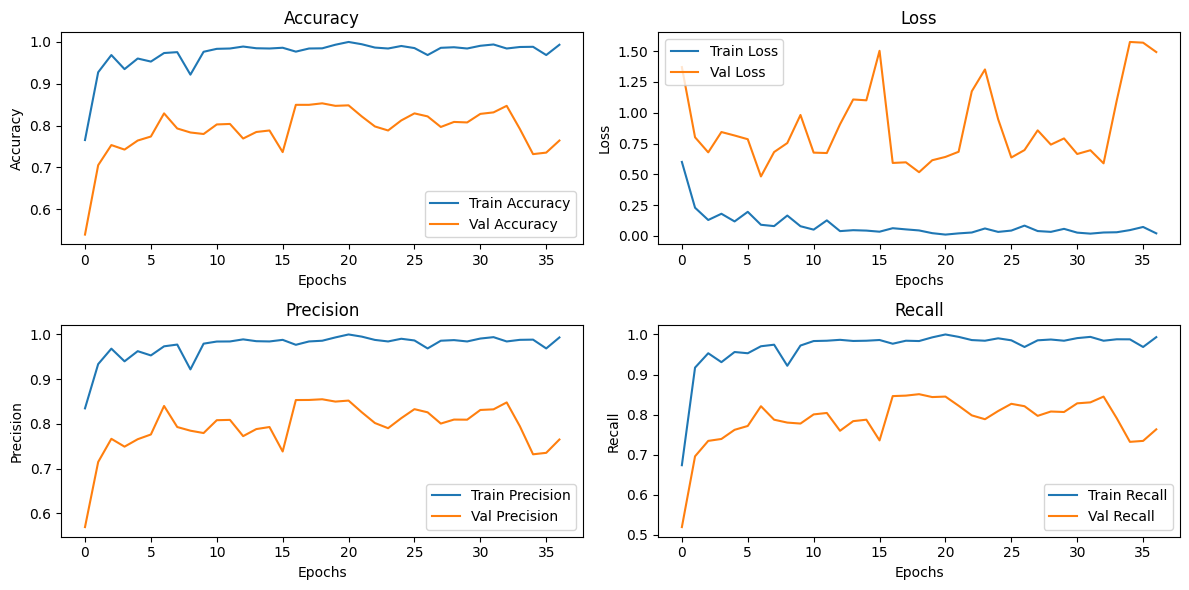

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(history_inceptionv3_tuner.history['accuracy'], label='Train Accuracy')
plt.plot(history_inceptionv3_tuner.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history_inceptionv3_tuner.history['loss'], label='Train Loss')
plt.plot(history_inceptionv3_tuner.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history_inceptionv3_tuner.history['precision_4'], label='Train Precision')
plt.plot(history_inceptionv3_tuner.history['val_precision_4'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history_inceptionv3_tuner.history['recall_4'], label='Train Recall')
plt.plot(history_inceptionv3_tuner.history['val_recall_4'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Prediction on New Images

In [ ]:
# Load an image
img_path = '/content/dataset/dataset_jpg_resize_224/diabetic_retinopathy/10007_right.jpg'
img = image.load_img(img_path, target_size=img_size)

# Convert the image to array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Normalize
img_array /= 255.0

# Make a prediction
pred = inceptionv3_tuner.predict(img_array)
class_idx = np.argmax(pred, axis=1)  # Get the class with the highest probability

# Mapping class index to disease label
class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
print(f'Predicted Class: {class_labels[class_idx[0]]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: diabetic_retinopathy


# Loading the Model

In [ ]:
# Load the best model saved by ModelCheckpoint
loaded_model = load_model(model_save_path)

# Recompile the model with the same configuration used during training
loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

# Evaluate the model on the validation set
val_loss, val_accuracy, val_precision, val_recall, val_f1_score = loaded_model.evaluate(
    val_data,
    steps=val_data.samples // val_data.batch_size
)

# Print evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1_score}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8212 - f1_score: 0.8243 - loss: 0.5052 - precision_6: 0.8351 - recall_6: 0.8139
Validation Loss: 0.4891532361507416
Validation Accuracy: 0.828125
Validation Precision: 0.8388683795928955
Validation Recall: 0.8197115659713745
Validation F1-Score: 0.8291792869567871


# Conclusion

I obtained the best model using **InceptionV3** with the following performance metrics:
- Loss: 0.49
- Accuracy: 0.83
- Precision: 0.84
- Recall: 0.82
- F1-Score: 0.83